In [2]:
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Deep\ Learning\ Project/multi-modal-music-genre-classification/
%ls

/content/drive/.shortcut-targets-by-id/171ooq7ooYWU0qxPszBUOL0gPzYTH3uuB/Deep Learning Project/multi-modal-music-genre-classification
4mula.ipynb             Audio_dataprep.ipynb  Melspectrogram@
4mula_metadata.parquet  final_data_2k.gsheet  spectrograms.csv


In [5]:
import pandas as pd
import numpy as np
import os, glob
import pyarrow.parquet as pq

In [6]:
NUM_GENRES = 10
DATASET_SIZE = 2000
LANGUAGE = 'en'

In [7]:
import tqdm
music_id_to_part = []
for filename in tqdm.tqdm(glob.glob("./Melspectrogram/4MULa_melspectrogram_part_*.parquet")):
    part = os.path.splitext(filename)[0].split("_")[-1]
    df = pd.read_parquet(filename, columns=['music_id'])
    df['part'] = part
    music_id_to_part.append(df)
music_id_to_part = pd.concat(music_id_to_part)
music_id_to_part.drop_duplicates(['music_id'], inplace=True)

100%|██████████| 91/91 [00:01<00:00, 58.33it/s]


In [8]:
metadata = pd.read_parquet("./4mula_metadata.parquet")
metadata.drop_duplicates(subset=['music_id'], inplace=True)
metadata.head()

,music_id,music_name,music_lang,music_lyrics,art_id,art_name,art_rank,main_genre,related_genre,related_art,related_music
0,3ade68b8g0b5ca0b3,Artemísia,pt-br,Não vai nascer\nPorque eu não quero\nPorque eu...,3ade68b7g5cb92ea3,Carne Doce,8399,Indie,"['Indie', 'Folk', 'MPB']",[],[]
1,3ade68b8g7668fea3,Chapadão,pt-br,Chapadão já alquebrado\nCofre de recordação\nD...,3ade68b7gfa400ea3,Goiá,9944,Sertanejo,['Sertanejo'],"[{'id': '3ade68b7g29961ea3', 'name': 'Biá e Go...",[]
2,3ade68b8g9d86ffa3,Cuckoo,en,Feels like I'm having a meltdown\nIt feels lik...,3ade68b7g48731ea3,Adam Lambert,985,Pop,"['Pop', 'Pop/Rock', 'Romântico', 'Rock', 'Danc...","[{'id': '3ade68b5g2677eda3', 'name': 'Pink'}, ...","[{'id': '3ade68b8g2649ffa3', 'name': 'As Mina ..."
3,3ade68b7g1589cea3,El Lobo,es,(Feat. Hector The Father) \n\nAWOOOOOOOO!!! \n...,3ade68b6g9601fda3,Alexis Y Fido,8187,Reggaeton,"['Reggaeton', 'Hip Hop', 'Electronica', 'Rap',...","[{'id': '3ade68b6g7796fda3', 'name': 'Angel Y ...",[]
4,3ade68b8geb5dd0b3,Meu Coração é o Teu Altar,pt-br,Que um altar dentro de mim seja erguido\nQue m...,3ade68b6g759eeda3,Eliane Silva,842,Gospel/Religious,"['Gospel/Religioso', 'Instrumental', 'Infantil...","[{'id': '3ade68b6g7c9cfda3', 'name': 'Amanda F...",[]


### Remove entries in metadata but not in data

In [9]:
metadata = pd.merge(music_id_to_part, metadata, how="left", on=["music_id"])

### Observe genres in the dataset

In [10]:
genres = pd.unique(metadata.main_genre)
print(f"There are {len(genres)} unique genres: {genres}")

eng_metadata = metadata[metadata['music_lang']==LANGUAGE]
print(eng_metadata['main_genre'].value_counts()[0:15].to_string())

There are 77 unique genres: ['Pagode' 'Forró' 'Rock' 'MPB' 'Emocore' 'Unknown' 'Pop/Rock' 'Dance'
 'Country' 'Rap' 'K-Pop/K-Rock' 'Gospel/Religious' 'Gothic' 'Sertanejo'
 'Hip Hop' 'Punk Rock' 'Samba Enredo' 'Folk' 'Romantic' 'R&B' 'Soundtrack'
 'Chillout' 'Samba' 'Alternative Rock' 'Fado' 'Axé' 'Pop' 'Indie'
 'World Music' 'Tecnopop' 'Hard Rock' 'Reggae' 'Progressive' 'Black Music'
 'Rockabilly' 'Electronic' 'Kids' 'Regional' 'Funk Carioca' 'Heavy Metal'
 'Funk' 'Velha Guarda' 'Disco' 'Soul Music' 'Blues' 'Hardcore'
 'Classic Rock' 'Soft Rock' 'Bossa Nova' 'Classic' 'Surf Music'
 'Reggaeton' 'Pop/Punk' 'Instrumental' 'Jazz' 'New Age' 'Post-Punk'
 'Grunge' 'Kizomba' 'J-Pop/J-Rock' 'Trance' 'New Wave' 'Jovem Guarda'
 'Trip-Hop' 'Power-Pop' 'House' 'Psicodelic' 'Músicas Gaúchas' 'Ska'
 'Piano Rock' 'Industrial' 'Tropical House' nan 'Metal' 'Post-Rock' 'Trap'
 'Electro Swing']
Rock                3536
Pop                 3043
Indie               2775
Unknown             2312
Heavy Metal  

### Select 10 of the most popular genres

In [11]:
selected_genres = ['Indie', 'Pop', 'Gospel/Religious', 'Rock', 'Romantic', 'Electronic', 'Rap', 'Hip Hop', 'R&B', 'Heavy Metal']
assert len(selected_genres)==NUM_GENRES
selected_cols = ['music_id', 'music_name', 'music_lang', 'music_lyrics', 'art_name', 'main_genre']
selected_metadata = eng_metadata[eng_metadata['main_genre'].isin(selected_genres)][selected_cols].reset_index()
selected_metadata

,index,music_id,music_name,music_lang,music_lyrics,art_name,main_genre
0,18,3ade68b7gc9a5dea3,Like A Boy,en,C-I-A-R-A\n\nPull up your pants\n(Just Like Em...,Ciara,Hip Hop
1,25,3ade68b8g895cd0b3,DOA,en,On our knees we pray\nAs we waste away\nAnd we...,I Prevail,Rock
2,27,3ade68b6g21f8fda3,I'm Coming Out,en,I'm coming out \nI'm coming \nI'm coming out \...,Amerie,R&B
3,35,3ade68b8g895fdfa3,Everything You Do,en,Do do do do do do do do do\nDo do do do do do ...,He Is We,Romantic
4,55,3ade68b8gac420fa3,Lost In Your Eyes,en,"I guess it's hard for me to say,\n\nWhy my hea...",3 Deep,Hip Hop
...,...,...,...,...,...,...,...
17907,84481,3ade68b8gd5c6a0b3,Muddy Waters,en,Muddy waters\nWe are kneeling at the rivers ed...,LP,Indie
17908,84491,3ade68b8gce84d0b3,Circles,en,And wake up to make up what is real\nRotate yo...,P.O.D.,Rock
17909,84493,3ade68b8g8f09dfa3,Carry On Wayward Son,en,Carry on my wayward son\nThere'll be peace whe...,Stryper,Gospel/Religious
17910,84499,3ade68b8gb4d580b3,She'll Move,en,First time you let go\nYou have no choice\nI k...,Lucy Rose,Indie


### Sample equally from each genre

In [12]:
final_metadata = selected_metadata.groupby('main_genre', group_keys=False).apply(lambda x: x.sample(DATASET_SIZE//NUM_GENRES))
# final_metadata = selected_metadata.sample(DATASET_SIZE).reset_index(drop=True).sort_values(by='index')
final_metadata

,index,music_id,music_name,music_lang,music_lyrics,art_name,main_genre
4782,24201,3ade68b8g1cdafea3,Special Place,en,Turning back turning back\nTo my special place...,Infected Mushroom,Electronic
1004,4853,3ade68b8gedfebfa3,Take Over Control (feat. Eva Simons),en,Let's go take a ride in your car \nI will take...,Afrojack,Electronic
17706,83574,3ade68b8g5312d0b3,Au5 - Closer (Feat. Danyka Nadeau),en,I'm watchin' it end\nAgain and again\nI feel i...,NCS,Electronic
14985,71745,3ade68b8g8c3980b3,Undress Rehearsal,en,"Ooh, la la la\nLa la, la la la\nOoh, la la la\...",Timeflies,Electronic
2700,13475,3ade68b8g9a5760b3,Deja Vu,en,"Running out of air, I'm chasing after you\nAft...",Dvbbs,Electronic
...,...,...,...,...,...,...,...
4055,20569,3ade68b8gd38560b3,"I Can Dream, Can't I?",en,I can see\nNo matter how near you'll be\nYou'l...,Annie Lennox,Romantic
5042,25536,3ade68b7gfa852ea3,More,en,More than the greatest love the world has know...,Andy Williams,Romantic
16534,78606,3ade68b8g8e687fa3,Real Life,en,"In my mind, you're moving around my head\nAnd ...",Wet Wet Wet,Romantic
4317,21902,3ade68b8ga245fea3,Superman,en,"There are no words, to paint a picture of you ...",Joe Brooks,Romantic


### Get melspectrograms from full data

In [13]:
set(music_id_to_part['music_id']).intersection(set(final_metadata['music_id'])) == set(final_metadata['music_id'])

True

In [14]:
final_metadata = pd.merge(music_id_to_part, final_metadata, how="inner", on=['music_id'])

In [15]:
final_metadata.head()

,music_id,part,index,music_name,music_lang,music_lyrics,art_name,main_genre
0,3ade68b8gac420fa3,2,55,Lost In Your Eyes,en,"I guess it's hard for me to say,\n\nWhy my hea...",3 Deep,Hip Hop
1,3ade68b8g5aa38fa3,2,80,I Had A Dream,en,(Chorus)\nI had I dream I saw myself holding a...,Group 1 Crew,Gospel/Religious
2,3ade68b8g2afdd0b3,2,89,Cyanide,en,"I love dominantly\nYou make me weak, make me t...",Daniel Caesar,R&B
3,3ade68b8g1cdaafa3,2,97,All Night Long,en,I see everybody around\nBut it feels like we'r...,Alexandra Burke,Pop
4,3ade68b7ga3723ea3,2,104,Stay,en,(Williams)\nWell your mama don't mind (bop-bop...,The Hollies,Rock


In [17]:
spectrograms = []
for k, g in tqdm.tqdm(final_metadata.groupby('part')):
    filename = f"./Melspectrogram/4MULa_melspectrogram_part_{k}.parquet"
    df = pq.ParquetDataset(filename, use_legacy_dataset=False, filters=[('music_id','in',g.music_id)])
    spectrograms.append(df.read(columns = ['music_id', 'melspectrogram']).to_pandas())
spectrograms = pd.concat(spectrograms)
spectrograms

100%|██████████| 91/91 [24:33<00:00, 16.19s/it]


,music_id,melspectrogram
0,3ade68b8g90d5c0b3,"[[1230.27808, 1302.96899, 1385.95129, 1460.521..."
1,3ade68b7g2451dea3,"[[0.253844738, 0.357827634, 0.299079537, 0.286..."
2,3ade68b7g09cf3ea3,"[[16.2917004, 11.0746536, 19.1581726, 12.70412..."
3,3ade68b8g90ff6fa3,"[[12.4767904, 23.5574665, 52.1779213, 54.11869..."
4,3ade68b8g20a4d0b3,"[[0.0279831383, 0.00698107388, 0.0017085647, 0..."
...,...,...
13,3ade68b8g493fdea3,"[[0.0200914089, 0.00815145485, 0.0199598484, 0..."
14,3ade68b8g43b7bfa3,"[[0.0406030864, 0.0139439031, 0.0096251145, 0...."
15,3ade68b7g63c94ea3,"[[0.00198460114, 0.00115074578, 0.000372220384..."
16,3ade68b8g8f09dfa3,"[[24.1071796, 5.92469883, 0.0383412205, 0.0804..."


In [18]:
print(spectrograms['music_id'].value_counts())
spectrograms.drop_duplicates(subset=['music_id'], inplace=True)

3ade68b7g69306ea3    3
3ade68b8g90d5c0b3    1
3ade68b8g2456b0b3    1
3ade68b8g8bc690b3    1
3ade68b7g16480ea3    1
                    ..
3ade68b8g44288fa3    1
3ade68b8gc6d96fa3    1
3ade68b7g40552ea3    1
3ade68b8g28e7b0b3    1
3ade68b8gb4d580b3    1
Name: music_id, Length: 2000, dtype: int64


In [19]:
spectrograms.to_pickle('spectrograms.csv')

### Final data

In [20]:
data = pd.merge(spectrograms, final_metadata, how = "inner", on = ["music_id"])
data

,music_id,melspectrogram,part,index,music_name,music_lang,music_lyrics,art_name,main_genre
0,3ade68b8g90d5c0b3,"[[1230.27808, 1302.96899, 1385.95129, 1460.521...",1,1006,Give Love (Feat. Lunchmoney Lewis),en,"My, my, my mother was a sunshine soldier\nEver...",Andy Grammer,Pop
1,3ade68b7g2451dea3,"[[0.253844738, 0.357827634, 0.299079537, 0.286...",1,1024,P.D.A. (We Just Don't Care),en,Let's go to the park\nI wanna kiss you underne...,John Legend,R&B
2,3ade68b7g09cf3ea3,"[[16.2917004, 11.0746536, 19.1581726, 12.70412...",1,1055,My Friend The Wind,en,My friend the wind will come from the hills\nW...,Demis Roussos,Romantic
3,3ade68b8g90ff6fa3,"[[12.4767904, 23.5574665, 52.1779213, 54.11869...",1,1094,All Things Are Possible,en,"Almighty God, my redeemer \nMy hiding place, m...",Darlene Zschech,Gospel/Religious
4,3ade68b8g20a4d0b3,"[[0.0279831383, 0.00698107388, 0.0017085647, 0...",1,1140,White Bronco,en,"Woo, woo, ah\nWoo, yeah, yeah\nWoo, yeah, yeah...",Action Bronson,Rap
...,...,...,...,...,...,...,...,...,...
1995,3ade68b8g493fdea3,"[[0.0200914089, 0.00815145485, 0.0199598484, 0...",91,84443,People Need The Lord,en,"Everyday they pass me by,\nI can see it in the...",Steve Green,Gospel/Religious
1996,3ade68b8g43b7bfa3,"[[0.0406030864, 0.0139439031, 0.0096251145, 0....",91,84445,Letting Go (Dutty Dutty) (feat. Nicki Minaj),en,"Ay' yo Sean, you Mr. Kingston\n\nDutty Dutty D...",Sean Kingston,Pop
1997,3ade68b7g63c94ea3,"[[0.00198460114, 0.00115074578, 0.000372220384...",91,84479,I Wish,en,"I wish to give, to take, to make, to shake\nI ...",Skazi,Electronic
1998,3ade68b8g8f09dfa3,"[[24.1071796, 5.92469883, 0.0383412205, 0.0804...",91,84493,Carry On Wayward Son,en,Carry on my wayward son\nThere'll be peace whe...,Stryper,Gospel/Religious


In [21]:
data['main_genre'].value_counts()

Pop                 200
R&B                 200
Romantic            200
Gospel/Religious    200
Rap                 200
Indie               200
Heavy Metal         200
Hip Hop             200
Electronic          200
Rock                200
Name: main_genre, dtype: int64

In [22]:
data['music_id'].value_counts()

3ade68b8g90d5c0b3    1
3ade68b8geb20c0b3    1
3ade68b8g4cfed0b3    1
3ade68b8g8bc690b3    1
3ade68b7g16480ea3    1
                    ..
3ade68b8g44288fa3    1
3ade68b8gc6d96fa3    1
3ade68b7g40552ea3    1
3ade68b8g28e7b0b3    1
3ade68b8gb4d580b3    1
Name: music_id, Length: 2000, dtype: int64

In [23]:
data.to_pickle("final_data_2k.csv")

### Visualizing a spectrogram

In [24]:
import matplotlib.pyplot as plt
import librosa, librosa.display

### Load data from npy file

In [25]:
df = pd.read_pickle('final_data_2k.csv')
mel_sample = df.sample()
mel_sample = np.vstack(mel_sample['melspectrogram'].values[0])
mel_sample.shape

(128, 1292)

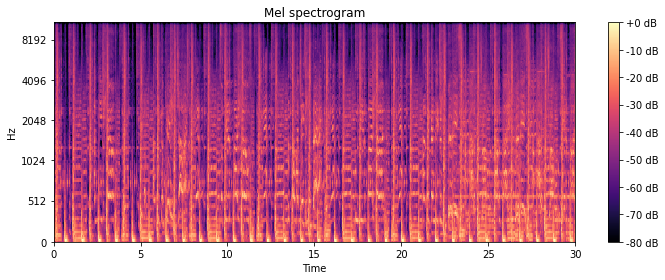

In [26]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_sample, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [28]:
!git config --global user.email "kritika29498@gmail.com"
!git config --global user.name "kritika-gupta"

In [42]:
!git add 4mula.ipynb
!git commit -m "Use pickle to save data"
# !git push origin main

[master a59ac79] Use pickle to save data
 1 file changed, 1 insertion(+), 1 deletion(-)


In [49]:
!git status

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [50]:
%ls

 4mula.ipynb             'Copy of 4mula.ipynb'   Melspectrogram@
 4mula_metadata.parquet   final_data_2k.csv      spectrograms.csv
 Audio_dataprep.ipynb     final_data_2k.gsheet


In [51]:
%cd ../

/content/drive/.shortcut-targets-by-id/171ooq7ooYWU0qxPszBUOL0gPzYTH3uuB/Deep Learning Project


In [52]:
%ls

4mula_metadata.parquet      Data/
4MULa_mfcc_part_56.parquet  multi-modal-music-genre-classification/


In [ ]:
%mv -r multi-modal-music-genre-classification/